In [1]:
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torchvision.transforms as T
import numpy as np
import matplotlib as plot
import os

In [2]:
label_colors = []
for i in range(4):
    for j in range(4):
        for k in range(4):
            label_colors.append((i*64,j*64,k*64))
print(len(label_colors))

64


In [3]:
def encode_segmap(image, nc=64):
    #from (h,w,3) to (h,w)
    label = np.zeros((720,960))
    image = image // 64 * 64
    for i in range(720):
        for j in range(960):
            try:
                label[i,j] = label_colors.index(tuple(image[i,j,:]))
            except:
                label[i,j] = 0
    return label

def decode_segmap(image, nc=64):
    #from (h,w) to (h,w,3)
    rgb = np.zeros((720,960,3))
    for i in range(720):
        for j in range(960):
            rgb[i,j,:] = label_colors[int(image[i,j])]
    return rgb.astype(np.uint8)

In [4]:
'''
target = 'SYNTHIA_RAND_CVPR16_extract-100-images/GT/'
label_dir = 'SYNTHIA_RAND_CVPR16_extract-100-images/label/'
for i,photo in enumerate(os.listdir(target)):
    path = target + photo
    label = np.array(Image.open(path).convert("RGB"))
    save_dir = label_dir + photo.split('.')[0] + '.npy'
    label = encode_segmap(label)
    np.save(save_dir,label)
    print('generating and saving label...[%d/%d]'%(i+1,len(os.listdir(target))),end='\r')
'''

'\ntarget = \'SYNTHIA_RAND_CVPR16_extract-100-images/GT/\'\nlabel_dir = \'SYNTHIA_RAND_CVPR16_extract-100-images/label/\'\nfor i,photo in enumerate(os.listdir(target)):\n    path = target + photo\n    label = np.array(Image.open(path).convert("RGB"))\n    save_dir = label_dir + photo.split(\'.\')[0] + \'.npy\'\n    label = encode_segmap(label)\n    np.save(save_dir,label)\n    print(\'generating and saving label...[%d/%d]\'%(i+1,len(os.listdir(target))),end=\'\r\')\n'

In [5]:
class DealDataset(torch.utils.data.Dataset):
    def __init__(self,images_path,labels_path,Transform = None,Transform_label = None):
        self.images_path_list = os.listdir(images_path)
        self.labels_path_list = [x.split('.')[0]+'.npy' for x in os.listdir(images_path)]
        self.transform = Transform
        self.transform_label = Transform_label
    def __getitem__(self,index):
        image_path = self.images_path_list[index]
        label_path = self.labels_path_list[index]
        
        image = Image.open(images_path + image_path).convert("RGB")
        label = np.load(labels_path + label_path)
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.transform_label is not None:
            label = self.transform_label(label)
        
        return image,label
        
    def __len__(self):
        return len(self.images_path_list)

images_path = 'SYNTHIA_RAND_CVPR16_extract-100-images/IMG/'
labels_path = 'SYNTHIA_RAND_CVPR16_extract-100-images/label/'
trf = T.Compose([T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
dataset = DealDataset(images_path,labels_path,Transform = T.Compose([T.ToTensor(),T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])]),Transform_label = T.ToTensor())
print(dataset[0][0].shape,dataset[0][1].shape)

torch.Size([3, 720, 960]) torch.Size([1, 720, 960])


In [8]:
model_64 = models.segmentation.fcn_resnet101(pretrained = False,num_classes=64)#64类模型
loss_fn  = torch.nn.CrossEntropyLoss()

use_cuda = True
if use_cuda:
    model_64.cuda()
    loss_fn.cuda()

save_list = []
for param_tensor in model_64.state_dict():
    if 'classifier' not in param_tensor and 'aux_classifier' not in param_tensor:
        save_list.append(param_tensor)#去掉不匹配的classifier和aux_classifier参数，保留共有的参数
model_21 = models.segmentation.fcn_resnet101(pretrained = True,num_classes=21)#载入21类模型

#把模型参数移植到64类之中

if use_cuda:
    load_state = {k: v.cuda() for k, v in model_21.state_dict().items() if k in save_list}
else:
    load_state = {k: v for k, v in model_21.state_dict().items() if k in save_list}

model_state = model_64.state_dict()
model_state.update(load_state)
model_64.load_state_dict(model_state)

#固定载入的参数
for name, value in model_64.named_parameters():
    if name in save_list:
        value.requires_grad = False

In [11]:
model_64.train()
optimizer = optim.Adam(model_64.parameters(), lr=0.001)
EPOCH = 10
#训练没有固定的参数
for epoch in range(EPOCH):
    for i in range(len(dataset)):
        if use_cuda:
            out = (model_64(dataset[i][0].cuda().unsqueeze(dim=0))['out'])
            target = dataset[i][1].cuda().long()
        else:
            out = (model_64(dataset[i][0].unsqueeze(dim=0))['out'])
            target = dataset[i][1].long()
        loss = loss_fn(out,target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print('Train Loss: %.6f\tEPOCH:[%d/%d]\tSTEP:[%d/%d]'%(loss.data.item(),epoch+1,EPOCH,i+1,len(dataset)))

Train Loss: 4.240561	EPOCH:[1/10]	STEP:[1/100]
Train Loss: 2.596343	EPOCH:[1/10]	STEP:[2/100]
Train Loss: 2.502120	EPOCH:[1/10]	STEP:[3/100]
Train Loss: 2.331738	EPOCH:[1/10]	STEP:[4/100]
Train Loss: 1.918356	EPOCH:[1/10]	STEP:[5/100]
Train Loss: 1.713203	EPOCH:[1/10]	STEP:[6/100]
Train Loss: 1.581247	EPOCH:[1/10]	STEP:[7/100]
Train Loss: 1.532525	EPOCH:[1/10]	STEP:[8/100]
Train Loss: 1.462321	EPOCH:[1/10]	STEP:[9/100]
Train Loss: 1.188675	EPOCH:[1/10]	STEP:[10/100]
Train Loss: 2.188315	EPOCH:[1/10]	STEP:[11/100]
Train Loss: 1.689978	EPOCH:[1/10]	STEP:[12/100]
Train Loss: 1.993460	EPOCH:[1/10]	STEP:[13/100]
Train Loss: 1.541075	EPOCH:[1/10]	STEP:[14/100]
Train Loss: 1.433111	EPOCH:[1/10]	STEP:[15/100]
Train Loss: 1.562332	EPOCH:[1/10]	STEP:[16/100]
Train Loss: 1.215564	EPOCH:[1/10]	STEP:[17/100]
Train Loss: 1.096773	EPOCH:[1/10]	STEP:[18/100]
Train Loss: 1.014257	EPOCH:[1/10]	STEP:[19/100]
Train Loss: 1.021472	EPOCH:[1/10]	STEP:[20/100]
Train Loss: 1.081121	EPOCH:[1/10]	STEP:[21/100]


KeyboardInterrupt: 

In [9]:
#保存模型
torch.save(model_64.state_dict(), 'ckpt.pth')

In [21]:
#模型推理
checkpoint = torch.load('ckpt.pth')
model_64.load_state_dict(checkpoint)
model_64.eval()
out = (model_64(dataset[0][0].unsqueeze(dim=0))['out'])
out.shape

torch.Size([1, 64, 720, 960])

In [22]:
#展示函数
def display(x):
    if len(x.shape) == 4:
        x = torch.argmax(x,dim=1)
    if len(x.shape) == 3:
        img = decode_segmap(x.squeeze().numpy())
    else:
        img = decode_segmap(x.numpy())
    plt.imshow(img)
    plt.show()

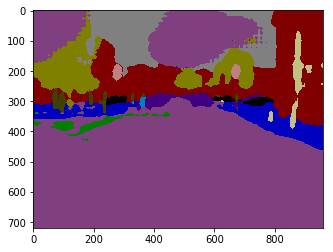

In [23]:
display(out)
#预测结果

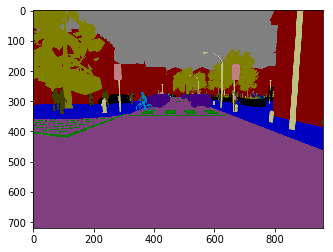

In [24]:
display(dataset[0][1])
#真实结果

In [32]:
#metric: confusion matrix and f1-score
nb_classes = 64
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i in range(len(dataset)):
        out = (model_64(dataset[i][0].unsqueeze(dim=0))['out'])
        pred = torch.argmax(out, 1)
        target = dataset[i][1]
        for t, p in zip(target.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
        print('processing NO.%d/%d...'%(i+1,len(dataset)),end='\r')
print('confusion_matrix:\n',confusion_matrix.numpy().astype(int))

confusion_matrix:/100...
 [[224601      0      0 ...      0   1491      0]
 [  3462      0      0 ...      0     34      0]
 [  5528      0      0 ...      0     94      0]
 ...
 [     0      0      0 ...      0      0      0]
 [  4383      0      0 ...      0 412044      0]
 [     0      0      0 ...      0      0      0]]


In [33]:
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print('precision:\n',(confusion_matrix.diag()/confusion_matrix.sum(1)).numpy())

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print('recall:\n',(confusion_matrix.diag()/confusion_matrix.sum(0)).numpy())

f1 = 2*precision*recall/(precision+recall)
print('f1-score:\n',f1.numpy())

precision:
 [7.1081442e-01 0.0000000e+00 0.0000000e+00 8.1663042e-01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 4.9799275e-02 7.1826249e-01 0.0000000e+00
 0.0000000e+00 6.9589281e-01           nan           nan           nan
           nan 1.5673631e-04 0.0000000e+00 7.7213579e-01           nan
 5.3097147e-01 0.0000000e+00 0.0000000e+00           nan 0.0000000e+00
 0.0000000e+00 0.0000000e+00           nan           nan           nan
           nan           nan 7.6970524e-01 0.0000000e+00           nan
           nan 5.8169191e-04 0.0000000e+00 9.7893721e-01           nan
 7.0968211e-01 5.5381388e-04 5.7784492e-01           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan           nan           nan
           nan           nan           nan 6.5808445e-01           nan
           nan           nan 6.5468758e-01           nan]
recall:
 [0.37254122        nan 0.         0.9298028         nan        nan
  